In [3]:
#import BALTIC: repo needs to be cloned in if you don't have it yet.
import imp
bt = imp.load_source('baltic', '/Users/alliblk/Desktop/gitrepos/baltic/baltic.py')


In [73]:
#import necessary libraries
import re
import copy
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

from matplotlib import font_manager as fm
fm.findfont('Helvetica')

u'/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf'

In [18]:
tree_path='/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/prelimGLM10-24-2017/AmZika_markovJumpGLM.mcc'
print "File: %s"%(tree_path.split('/')[-1]) #make sure I have the right file

File: AmZika_markovJumpGLM.mcc


In [59]:
estimatedTipDates = '/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/prelim10-23-2017/chain1AmZika-StrictClock-BS50.tipDates.log'
taxonNames = []
with open(estimatedTipDates, 'rU') as file:
    for line in file:
        if line.startswith('#'): #comments at start of file
            continue
        elif line.startswith('state'): #header line of file with taxon names
            for element in line.split('\t'):
                element = element.replace('age(','').replace(')','').strip()
                taxonNames.append(element)
                
estimTipDates_df = pd.read_table(estimatedTipDates, sep='\t', skiprows=[0,1,2]) #skip comment lines written to log file
estimTipDates_df  = estimDates.keys()
burninTreeDates = int(round(len(estimTipDates_df)*0.1))


In [91]:
# get dates and ages
mostRecentTip = 2017.295890410959
tipLogDict = estimTipDates_df.to_dict(orient='list')
meanAges = {key:np.mean(tipLogDict[key][burnin:]) for key in tipLogDict.keys()} #get mean age of a taxon excluding burnin period
meanDecimalDates = {key:mostRecentTip-meanAges[key] for key in meanAges.keys()} #get sampling decimal dates as most recent tip - age
print meanDecimalDates

{'Paraiba_01|2015-XX-XX|south_america|brazil': 2015.5172686497326, 'COL/FLR/2015|2015-12-XX|south_america|colombia': 2015.9579917767267, 'V17271|2015-12-XX|south_america|french_guiana': 2015.9542607777935, 'Natal_RGN|2015-XX-XX|south_america|brazil': 2015.7667973855976, 'Bahia03|2015-05-XX|south_america|brazil': 2015.3788275242187, 'SPH2015|2015-03-XX|south_america|brazil': 2015.2031498347519, 'Bahia01|2015-05-XX|south_america|brazil': 2015.3731229562379, 'MEX_I_7|2015-11-XX|north_america|mexico': 2015.8781887142445, 'Brazil/2016/ZBRY10|2016-01-XX|south_america|brazil': 2016.0402332082642, 'state': -64347982.704109587, 'HS_2015_BA_01|2015-08-XX|south_america|brazil': 2015.6297753439649, 'Brazil/2016/ZBRY8|2016-01-XX|south_america|brazil': 2016.0384881077821, 'PRVABC59|2015-12-XX|north_america|puerto_rico': 2015.9584180320185, 'Brazil/2016/ZBRY7|2016-01-XX|south_america|brazil': 2016.042362862657, 'Brazil/PE243/2015|2015-XX-XX|south_america|brazil': 2015.4492478511706, 'EcEs062_16|2016-

In [360]:
#Read tree in to baltic object
tipFlag=False ## used to keep track of where we are in FigTree format
tips={} ## dictionary of tip code to full tip name

for line in open(tree_path,'rU'): ## iterate through FigTree file's lines
    line = line.strip('\n') ## strip newline characters from each line
    tip_count_match =re.search('dimensions ntax=([0-9]+);',line.lower()) ## check how many tips you have
    #print tip_count
    if tip_count_match is not None:
        tipNum=int(tip_count_match.group(1)) 

print 'There were {} leaves found in the imported tree.'.format(tipNum) #should be 256 now that french pol outgroup has been removedd.

for line in open(tree_path,'rU'):
    line = line.strip('\n')
    tree_string_match = re.search('tree TREE([0-9]+) = \[&R\]',line) ## search for beginning of tree string in BEAST format
    if tree_string_match is not None:
        treeString_start = line.index('(') ## tree string starts where the first '(' is in the line
        #print treeString_start
        linked_list = bt.tree() ## new instance of tree
        bt.make_tree(line[treeString_start:],linked_list) ## send tree string to make_tree function, provide an empty tree object

for line in open(tree_path,'rU'):
    line = line.strip('\n')
    if tipFlag==True:
        tip_match = re.search('([0-9]+) ([A-Za-z\-\_\/\.\'0-9 \|?]+)',line) 
        ## look for tip name map, where each tip is given an integer to represent it in tree
        if tip_match is not None:
            tips[tip_match.group(1)]=tip_match.group(2).strip("'") 
            ## if you give tips an integer (in the form of a string), it will return the full name of the tip
        elif ';' not in line: ## something's wrong - nothing that matches the tip regex is being captured where it should be in the file
            print 'tip not captured by regex:',line.replace('\t','')

    if 'translate' in line.lower(): ## start looking for tips, the tips text block is starting 
        tipFlag=True
    if ';' in line: ## stop looking for tips, the tips text block has ended
        tipFlag=False

print "Number of objects (leaves and internal nodes) found in tree string: {}".format(len(linked_list.Objects)) #this should be n leaves, and n-1 internal nodes

if len(tips)==0: ## use this if tip names in the string are already the final format
    for k in linked_list.Objects:
        if isinstance(k,bt.leaf):
            k.name=k.numName
else: ## there's a tip name map at the beginning, so translate the names (so that you're not using the taxon numbers)
    linked_list.renameTips(tips) ## name tips according to full taxon names that map to the integer names, stored in dictionary
    for k in linked_list.Objects:
        if isinstance(k,bt.leaf): #if the object is a leaf
            if k.name in meanDecimalDates.keys(): #grab decimal dates from dict above if not fully specified in taxon name
                k.absoluteTime = meanDecimalDates[k.name]
            else: #if sampling date is fully specificed with y-m-d in the name, take this information from the name.
                k.absoluteTime = bt.decimalDate(k.name.strip("'").split('|')[1],variable=True)

highestTip = max([k.absoluteTime for k in linked_list.Objects if isinstance (k, bt.leaf)])
print highestTip

print "The youngest sample was collected on {}.".format(highestTip)
#print "The youngest sample is {} units x axis, where the root has x = 0.".format(highestTipinYearsFromRoot)

print 'Additional statistics about the tree!'
linked_list.treeStats()

linked_list.traverse_tree()

linked_list.drawTree()

linked_list.sortBranches(descending=False) #this sortBranches command will give each node or leaf object a k.x and k.y coordinate


#this is the youngest tip, given not by the sampling date, but by the number of years that have passed since the root  (where root = 0)
highestTipinYearsFromRoot = max([k.x for k in linked_list.Objects if isinstance (k, bt.leaf)]) 
print highestTipinYearsFromRoot
#also, since the nodes don't inherently have an absoluteTime trait (because it can't be grabbed from the name), I'm going to make one.
#node ages are measured in distance from root, where root is 0. Thus the internal nodes are (k.x) distance from the root, which means 
#they are (highestTipinYearsFromRoot - k.x) years older than the highest tip.
#therefore, absolute age can be determined for the internal nodes by taking [highestTip - (highestTipinYearsFromRoot - k.x) ]
for k in linked_list.Objects:
    if isinstance(k, bt.node):
        k.absoluteTime = (highestTip - (highestTipinYearsFromRoot - k.x))

There were 256 leaves found in the imported tree.
Number of objects (leaves and internal nodes) found in tree string: 511
2017.29589041
The youngest sample was collected on 2017.29589041.
Additional statistics about the tree!

Tree height: 3.008983
Tree length: 164.498765
strictly bifurcating tree
annotations present

Numbers of objects in tree: 511 (255 nodes and 256 leaves)

3.00898328538


In [330]:
#group countries and colors.
northAm = []
southAm = []
centralAm = []
carib = []
countries = []

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/glm/indexed-countries-45.tsv','r') as file:
    for line in file:
        if line.startswith('country'):
            continue
        else:
            countries.append(line.split('\t')[0])
            if line.split('\t')[1].strip() == 'north_america':
                northAm.append(line.split('\t')[0])
            elif line.split('\t')[1].strip() == 'central_america':
                centralAm.append(line.split('\t')[0])
            elif line.split('\t')[1].strip() == 'south_america':
                southAm.append(line.split('\t')[0])
            elif line.split('\t')[1].strip() == 'caribbean':
                carib.append(line.split('\t')[0])                

print len(southAm)
print len(northAm)
print len(carib) 
print len(centralAm)
print len(countries)

northAmcolor = '#ddcc77'#'#44AA99'
southAmcolor =  '#332288'#'#CC6677'
centralAmcolor = '#AA4499'
caribColor = '#999933'

13
4
21
7
45


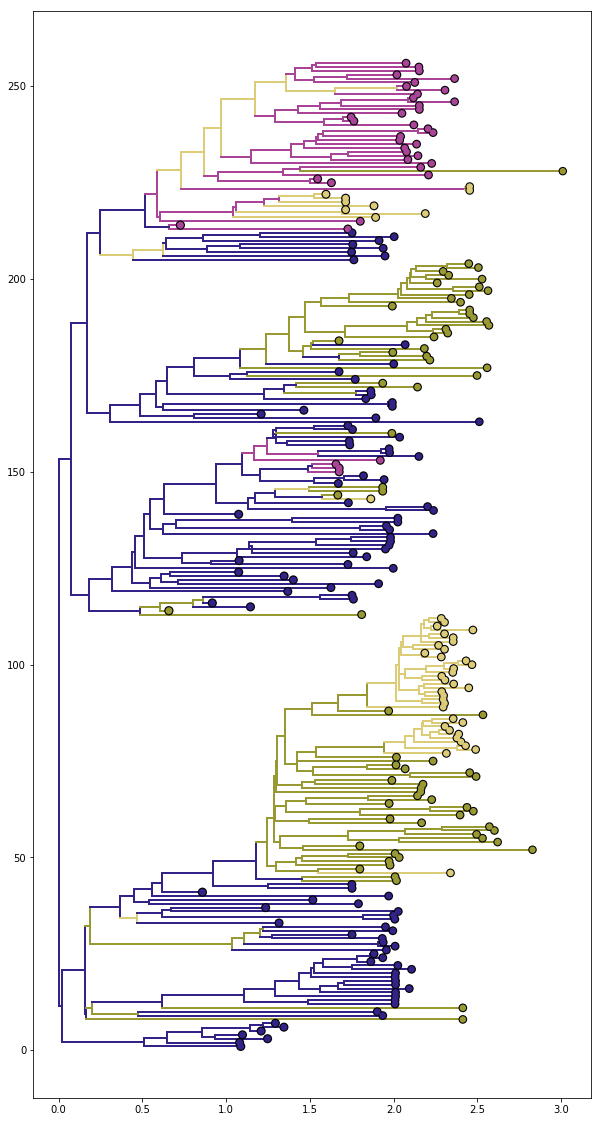

In [306]:
#This works when x values remain as ages from youngest tip.
#Tree plots BACKWARDS when AbsoluteTime is used...WHY???
### NOTE: root x value is 0, and .x values count from that. this is opposite to figtree where 0 == youngest tip!
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')
branchWidth=2 ## default branch width
cmap=mpl.cm.viridis

for k in linked_list.Objects:
    x = k.x
    y = k.y
    xp = k.parent.x
    if xp == None:
        xp = x ## get x position of current node's parent
    
    if isinstance(k,bt.leaf):
        if k.name.split('|')[3] in northAm:
            color = northAmcolor
        elif k.name.split('|')[3] in southAm:
            color = southAmcolor
        elif k.name.split('|')[3] in centralAm:
            color = centralAmcolor
        elif k.name.split('|')[3] in carib:
            color = caribColor

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        s=50-10*k.height/linked_list.treeHeight #size to draw the circle
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[0].y,k.children[1].y],lw=branchWidth,color=color,ls='-',zorder=9) # x to x, these are the vertical branches
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9)

3.00898328538


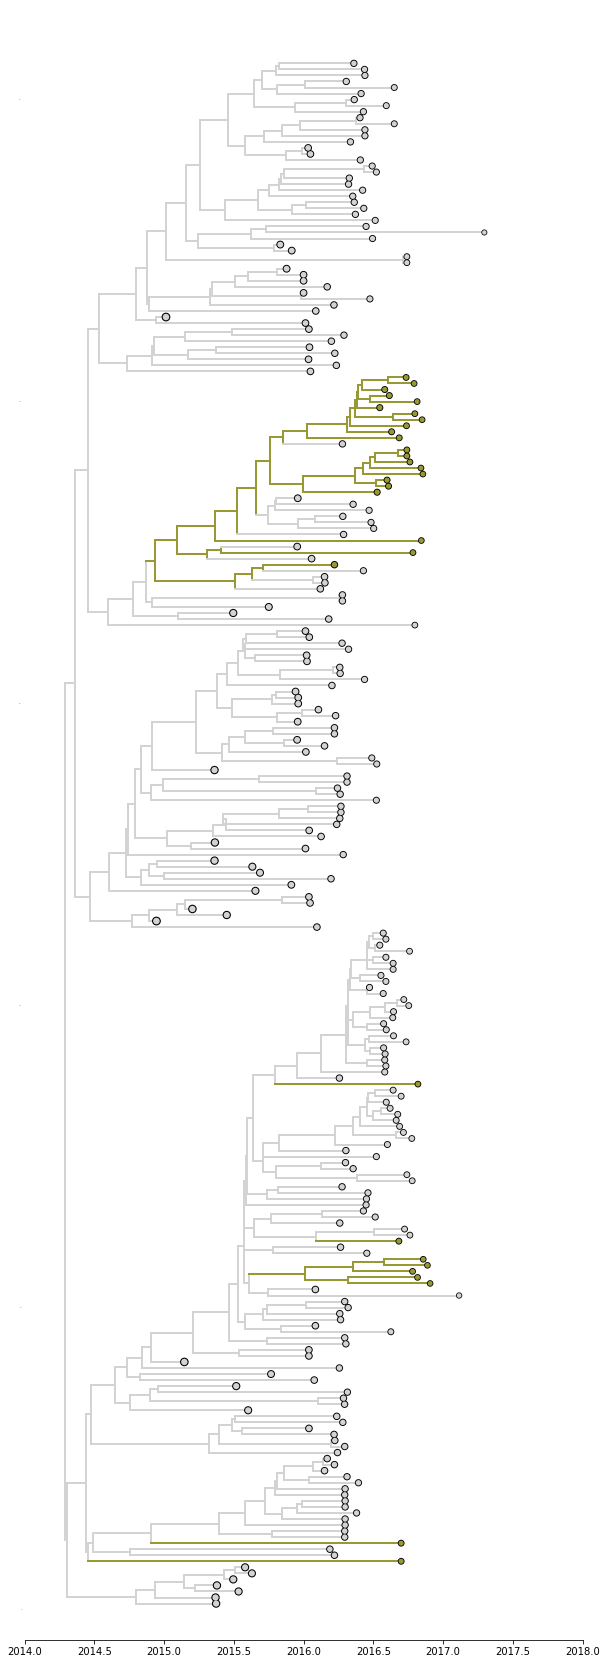

In [362]:
#here's how to make plotting in absolute time scale work!
#note there's a bit of weirdness because k.x is counted up from root = 0, not the difference in age to the youngest tip
#that means that to get number of years behind the highest tip, you need to know the distance from the leaf k.x value to the node k.x value
#which is the youngest tip's k.x value - your node's k.x value. And this is the number you need to substract from absolute time.

fig,ax = plt.subplots(figsize=(10,30),facecolor='w')
branchWidth=2 ## default branch width
cmap=mpl.cm.viridis

highestTipinYearsFromRoot = max([k.x for k in linked_list.Objects if isinstance (k, bt.leaf)])
print highestTipinYearsFromRoot

for k in linked_list.Objects:
    #x = highestTip - (highestTipinYearsFromRoot - k.x)
    x = k.absoluteTime
    y = k.y
    if k.parent.x == None:
        xp = x
    else:  
        #xp = highestTip - (highestTipinYearsFromRoot - k.parent.x) ## get x position of current node's parent
        xp = k.parent.absoluteTime

    color=[caribColor if k.traits['country.states']=='united_states_virgin_islands' else 'lightgrey'][0] ## can be discrete too

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        s=50-30*k.height/linked_list.treeHeight #size to draw the circle
        ax.scatter(x,y,s=s,facecolor=color,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        ax.plot([x,x],[k.children[0].y,k.children[1].y],lw=branchWidth,color=color,ls='-',zorder=9) # x to x, these are the vertical branches
        
    ax.plot([xp,x],[y,y],lw=branchWidth,color=color,ls='-',zorder=9)
    
#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='top',labelsize=0,size=0)

ax.set_xlim(2014,2018)
ax.set_ylim(-5,len(linked_list.Objects)/2+10)

plt.show()

In [391]:
#From EBOV
traitName='country.states'
# traitName='location'
linked_list.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch
linked_list.root.y=0
linked_list.root.x= highestTip - highestTipinYearsFromRoot


#this dict stores subtrees where keys are countries that the virus jumped in to, and the value is a list with the parent country, and the subtree object:
#e.g.within_country_trees['united_states_virgin_islands'] would return multiple values, with the first being ('brazil', <baltic.tree instance at 0x112fd3cb0>)
#thus this would be an introduction from brazil, to the usvi, with the subtree saved as a baltic tree object.
within_country_trees={}


#this dictionary remembers how many leaves are in each country's subtree.
subtree_sizes={country:[] for country in countries}
subtree_lengths={country:[] for country in countries}
subtree_strings = {country:[] for country in countries}

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees.log', 'w') as file:
    file.write('origin_country\tdestination_country\tclade_TMRCA\tparent_TMRCA\tclade_size\tpersistence\ttree_string\n')

for k in sorted(linked_list.Objects,key=lambda x:x.height): ## iterate over branches, ordered by node.height, where root has the smallest height, and youngest tip has the greatest height
    kparent=k.parent
    
    kcountry=k.traits[traitName] #country that this node or leaf is in
    if k.parent.traits.has_key(traitName): #if the parent also has a designated country state
        kparentCountry = kparent.traits[traitName]
    else: ## if parent doesn't have a trait - dealing with root of tree
        kparentCountry = 'ancestor'
    
    if kcountry != kparentCountry: ## if the parent and the child are determined to be in different countries
        if isinstance(k,bt.node): ## and dealing with an internal node
            N_children=len(k.leaves)
        else: ## dealing with leaf...
            N_children=1
        
        within_country_subtree = linked_list.subtree(k,traitName=traitName) ## extract subtree during a within-trait traversal
        
        if within_country_subtree: ## if you have successfully extracted a subtree, and have a new tree object
            within_country_subtree_leaves=[x.name for x in within_country_subtree.Objects if isinstance(x,bt.leaf)] ## get leaves in resulting subtree
            print '{} to {} jump (ancestor {} had {} child leaves in full tree, now has {} child leaves with same trait state.)'.format(kparentCountry,kcountry,k.index,N_children,len(within_country_subtree_leaves))
            if within_country_trees.has_key(kcountry): #if receiving country already in dictionary
                within_country_trees[kcountry].append((kparentCountry,within_country_subtree)) #add subtree to dict based on where the lineage jumped to
            else: #a receiving country isn't in the dict yet, need to make a new key and value pair.
                within_country_trees[kcountry]=[(kparentCountry,within_country_subtree)]
            
            subtree_sizes[kcountry].append(len(within_country_subtree_leaves)) ## remember subtree size

### working to here
            mostRecentSubtreeTip = max([k.absoluteTime for k in within_country_subtree.Objects])

            #log the height of the subtree. Height is the total branch length from the midpoint of the branch that represents the country transition
            #to the most recently sampled tip in the subtree. Because some taxon names don't have complete y-m-d sampling dates, I'm using 
            #the k.absoluteTime trait that I made for all leaf and node objects earlier.
            subtree_lengths[kcountry].append((k.length*0.5)+(mostRecentSubtreeTip-k.absoluteTime))            
            subtree_strings[kcountry].append(within_country_subtree.toString()) ## remember subtree string, subtree object itself

            persistence=mostRecentSubtreeTip-k.absoluteTime # this is amount of time that lineage stayed in a particular country
            ancestorTMRCA=k.parent.absoluteTime #sampling date for the ancestor to the subtree, which is in a different country
            cladeTMRCA=k.absoluteTime #sampling date of the first node of the subtree (in same country as rest of subtree)
            originCountry=kparentCountry #country that the subtree came from
            cladeSize=len(within_country_subtree_leaves)

            with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/beast/subtrees.log', 'a') as file:
                output = '{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(kparentCountry,kcountry,cladeTMRCA,ancestorTMRCA,cladeSize, persistence, within_country_subtree.toString())
                file.write(output)
            #print>>output_subtrees,'%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s'%(kc,kloc,kpc,kploc,cladeTMRCA,ancestorTime,len(subtree_leaves),persistence,subtreeString)

            #print>>output_members,'%s'%(','.join(subtree_leaves))
        
        
        
print 'done!'

ancestor to brazil jump (ancestor 0 had 256 child leaves in full tree, now has 72 child leaves with same trait state.)
brazil to haiti jump (ancestor 789662 had 6 child leaves in full tree, now has 2 child leaves with same trait state.)
brazil to honduras jump (ancestor 597509 had 44 child leaves in full tree, now has 22 child leaves with same trait state.)
brazil to united_states_virgin_islands jump (ancestor 425058 had 36 child leaves in full tree, now has 22 child leaves with same trait state.)
haiti to brazil jump (ancestor 795437 had 4 child leaves in full tree, now has 4 child leaves with same trait state.)
brazil to colombia jump (ancestor 869774 had 23 child leaves in full tree, now has 11 child leaves with same trait state.)
honduras to mexico jump (ancestor 605753 had 7 child leaves in full tree, now has 7 child leaves with same trait state.)
brazil to dominican_republic jump (ancestor 99773 had 69 child leaves in full tree, now has 21 child leaves with same trait state.)
col

In [396]:
usvi_specific_island = {}
with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/fastas/zika_usvi_good.fasta','rU') as file:
    for line in file:
        if line.startswith('>'):
            usvi_specific_island[line.strip('>').split('|')[0]] = line.split('|')[4] 

with open('/Users/alliblk/Desktop/gitrepos/zika-usvi/data/fastas/zika_usvi_partial.fasta','rU') as file:
    for line in file:
        if line.startswith('>'):
            usvi_specific_island[line.strip('>').split('|')[0]] = line.split('|')[4] 

(2014, 2017)

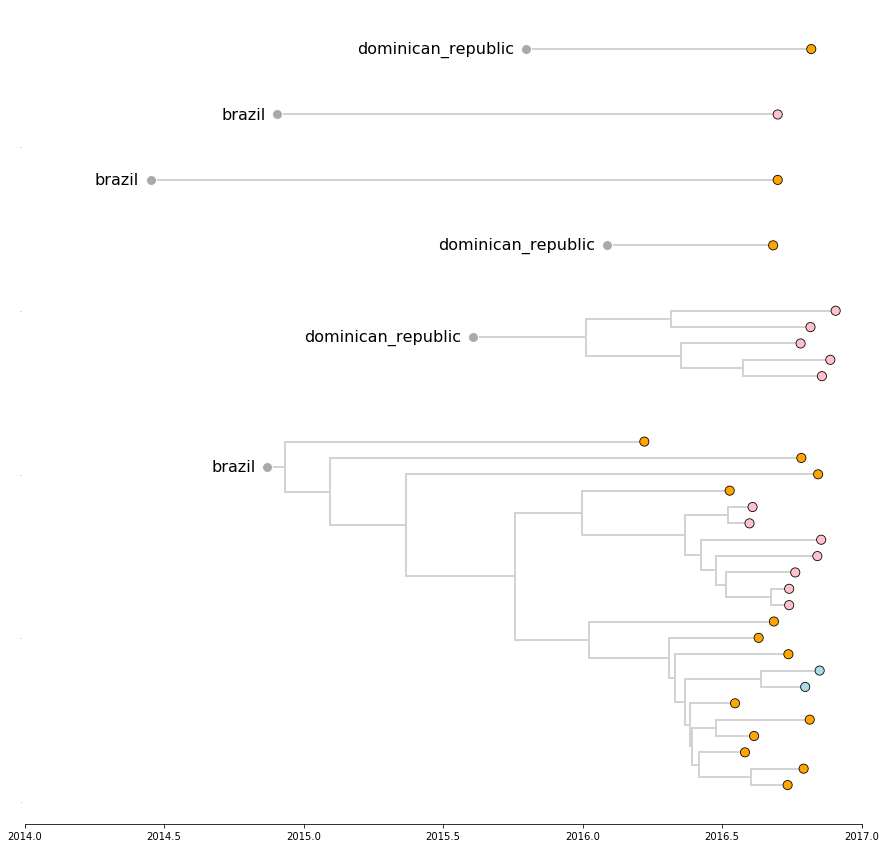

In [444]:
#print within_country_trees['united_states_virgin_islands']
#print subtree_sizes['united_states_virgin_islands']
usvi_island_colors = {'saint_croix': 'pink', 'saint_thomas': 'orange' ,'saint_john': 'lightblue'}


fig,ax = plt.subplots(figsize=(15,15),facecolor='w')
branchWidth=2 ## default branch width
tipSize = 70

cumulative_y = 0
for origin,subtree in within_country_trees['united_states_virgin_islands']: #iterating over introductions to the USVI
    for k in subtree.Objects:
        x = k.absoluteTime
        y = k.y
        if k.parent.x == None:
            xp = x
        else:  
            xp = k.parent.absoluteTime

        branch_color='lightgrey'
        
        if isinstance(k,bt.leaf): ## leaves have circles at tips
            island = usvi_specific_island[k.name.split('|')[0]]
            color = usvi_island_colors[island]
            ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=color,edgecolor='none',zorder=100) ## plot tip circle
            ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)

        elif isinstance(k,bt.node): ## nodes have vertical lines
            child1_y=k.children[0].y
            child2_y=k.children[-1].y
            ax.plot([x,x],[child1_y+cumulative_y,child2_y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot vertical bar 
        ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=branch_color,lw=branchWidth,zorder=98) ## plot branch
    
    min_node_x = min(k.absoluteTime for k in subtree.Objects)        
    origin_color='darkgrey'
                  
    if subtree.Objects[0].absoluteTime==None:
        origin_x=subtree.Objects[0].absoluteTime #sending country has same x coord as root in receiving country.
        origin_y=subtree.Objects[0].y+cumulative_y #and same for the y coordinates
    else:
        origin_x=subtree.Objects[0].parent.absoluteTime
        origin_y=subtree.Objects[0].y+cumulative_y

    if origin!='ancestor': ## add text if not dealing with the very first introduction into the americas
        ax.text(origin_x-15/365.0,origin_y,'{}'.format(origin),ha='right',va='center', size=16) ## uncomment to plot text at the beginning of the subtree to indicate its origin, only use with enough vertical space
        ax.scatter(origin_x,origin_y,100,facecolor=origin_color,edgecolor='w',lw=1,zorder=200) ## circle at the base of the subtree to indicate origin
        ax.plot([min_node_x,origin_x],[origin_y,origin_y],color=branch_color,lw=branchWidth,zorder=98)
        
    cumulative_y+=max([x.y for x in subtree.Objects])+3 ## increment y position

#Remove lines from sides of plot that I don't like
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='top',labelsize=0,size=0)

ax.set_xlim(2014,2017)
#ax.set_ylim(-5,len(linked_list.Objects)/2+10)
   

In [328]:
print len(linked_list.Objects)
print 

511


In [443]:
for origin,subtree in enumerate(sorted(within_country_trees['united_states_virgin_islands'],key=lambda x:(-x[1].root.absoluteTime))):
    print origin,subtree
    origin,tree=subtree
    print tree.Objects[0].absoluteTime

0 ('dominican_republic', <baltic.tree instance at 0x1133fbd40>)
2016.68306011
1 ('dominican_republic', <baltic.tree instance at 0x111f5a7e8>)
2016.81967213
2 ('dominican_republic', <baltic.tree instance at 0x110afab90>)
2016.01130588
3 ('brazil', <baltic.tree instance at 0x11054c098>)
2016.69945355
4 ('brazil', <baltic.tree instance at 0x11072a368>)
2014.93448431
5 ('brazil', <baltic.tree instance at 0x110e057a0>)
2016.69945355


In [429]:
for origin,subtree in sorted(within_country_trees['united_states_virgin_islands']):
    subtree.Objects[0].absoluteTime


2016.69945355
2014.93448431
2016.69945355
2016.01130588
2016.81967213
2016.68306011


In [307]:
#make and fix usvi subtrees
traitName='country.states'
branchWidth=2
tipSize=30

linked_list.root.traits[traitName]='ancestor' ## add fake trait to root of the tree

tree_strings={'usvi':[],'not_usvi':[],'ancestor':[]}
subtype_trees={'usvi':[],'not_usvi':[],'ancestor':[]}

for k in linked_list.Objects:
    kp = k.parent
    
    ## get current node's and its parent's trait states
    k_country = k.traits['country.states']
    if k.parent.traits.has_key('country.states'):
        kp_country=kp.traits['country.states']
    else:
        kp_country='ancestor'
    
    ## if states do not match
    if k_country!=kp_country:
        proceed=False
          
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if dealing with a leaf - proceed
            N_children=1
            proceed=True
        else:
            N_children=len(k.leaves)
            if [ch.traits[traitName] for ch in k.children].count(k_country)>=1: ## check if at least 1 child of a node is in the same state - proceed only if they are
                proceed=True
                
            print 'Both children within the same trait: %s (%s)'%(proceed,','.join([ch.traits[traitName] for ch in k.children]))

        if proceed==True:
            subtree=linked_list.subtree(k,traitName=traitName) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the trait value state of k
            
            tree_strings[k_country].append(subtree.toString()) ## remember subtree string, subtree object itself
            subtype_trees[k_country].append((kp_country,subtree))
            
print 'Done!'

Both children within the same trait: True (brazil,brazil)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
#make exploded subtrees

fig,ax = plt.subplots(figsize=(10,15),facecolor='w')

traitName='united_states_virgin_islands'
branchWidth=2
tipSize=20

cumulative_y=0

for subtype in ['V','Y']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        if len([ob for ob in loc_tree.Objects if isinstance(ob,bt.leaf)])>0: ## proceed only if there's at least one tip in subtree
            for w in loc_tree.Objects: ## iterate over subtree
                c=['indianred' if w.traits[traitName]=='V' else 'steelblue'][0] ## get colour

                y=w.y
                x=w.absoluteTime

                if y!=None:

                    if w.parent!=None:
                        xp=w.parent.absoluteTime
                        yp=w.parent.y
                    else:
                        xp=x
                        yp=y

                    if isinstance(w,bt.leaf): ## if leaf - plot tip circle
                        ax.scatter(x,y+cumulative_y,s=tipSize,facecolor=c,edgecolor='none',zorder=100)
                        ax.scatter(x,y+cumulative_y,s=tipSize+30,facecolor='k',edgecolor='none',zorder=99)

                    elif isinstance(w,bt.node): ## if node - plot vertical bar
                        yl=w.children[0].y
                        yr=w.children[-1].y
                        
                        ax.plot([x,x],[yl+cumulative_y,yr+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot vertical bar
                        
                    ax.plot([x,xp],[y+cumulative_y,y+cumulative_y],color=c,lw=branchWidth,zorder=98) ## plot branch
                    
                    

            oriC=['indianred' if origin=='V' else 'steelblue'][0]
            if loc_tree.Objects[0].absoluteTime==None:
                oriX=loc_tree.Objects[0].absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y
            else:
                oriX=loc_tree.Objects[0].parent.absoluteTime
                oriY=loc_tree.Objects[0].y+cumulative_y

            ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin

            cumulative_y+=max([x.y for x in loc_tree.Objects])+5 ## increment y displacement

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='y',size=0)
ax.set_yticklabels([])
ax.set_ylim(-5,cumulative_y)

plt.show()

{}
